In [1]:
import torch
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToSLIC

In [99]:
import matplotlib.pyplot as plt
from skimage.segmentation import slic
import skimage as ski

from multiprocessing import Pool

Example for visualization

In [3]:
ds = datasets.MNIST(root = "./data", train=False, download=True, transform=T.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [69]:
for d in ds:
    print(d[0].shape, d[1])
    break

torch.Size([1, 28, 28]) 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28)
RAG with 65 nodes and 186 edges


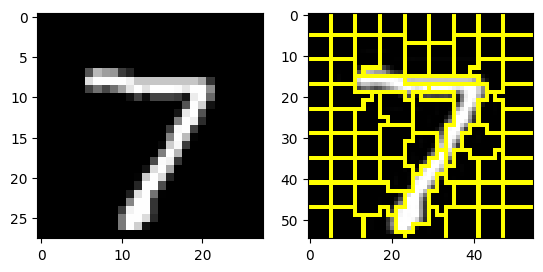

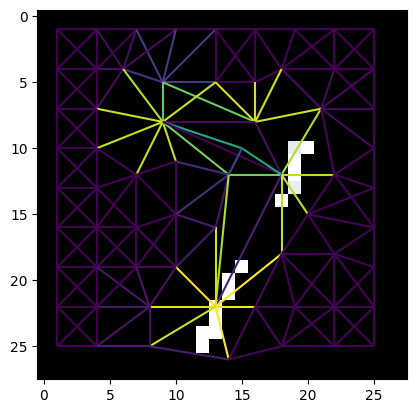

In [26]:
i = ds.data[0].numpy()
print(i.shape)
segments = slic(i, n_segments=75, compactness=0.1)
g = ski.future.graph.rag_mean_color(i, segments)
print(g)

fig, axs = plt.subplots(1,2)
axs[0].imshow(i, "gray")
segmented_img = ski.segmentation.mark_boundaries(i, segments, mode="subpixel")
axs[1].imshow(segmented_img, "gray")
ski.future.graph.show_rag(segments, g, ski.color.gray2rgb(i), edge_cmap='viridis')


For each node compute
- mean color 
- geometric centroid

Edge index from skimage's RAG

SuperPixel MNIST dataset

In [101]:
class SuperPixelGraphMNIST(InMemoryDataset):
    def __init__(self, root=None, n_segments = 75, compactness = 0.1, train = True, transform = None, pre_transform = None, pre_filter = None):
        self.n_segments = n_segments
        self.compactness = compactness
        self.train = train
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
    
    def loadMNIST(self, n_segments, compactness, train):
        mnist = datasets.MNIST('./data', train=train, download=True, transform=T.ToTensor())
        data_list = []
        img_total = mnist.data.shape[0]
        dim0, dim1 = mnist.data[0].shape[0], mnist.data[0].shape[1]
        print(f'Loading {img_total} images ...')
        with Pool() as p:
            data_list = p.map(self.create_data_obj, mnist)
        print('Done')
        return self.collate(data_list)

    def create_data_obj(self, d):
            img, y = d
            _, dim0, dim1 = img.shape
            img_np = img.view(dim0, dim1).numpy()
            s = slic(img_np, self.n_segments, self.compactness)
            g = ski.future.graph.rag_mean_color(img_np, s)
            n = g.number_of_nodes()
            x = np.zeros([n, 1]) # mean color
            pos = np.zeros([n, 2])
            num_pixels = np.zeros([n])
            for idx in range(dim0 * dim1):
                    idx_i, idx_j = idx % dim0, int(idx / dim0)
                    node = s[idx_i][idx_j] - 1
                    x[node][0]   = (num_pixels[node] * x[node][0]   + img_np[idx_i][idx_j]) / (num_pixels[node] + 1)
                    pos[node][0] = (num_pixels[node] * pos[node][0] + idx_i) / (num_pixels[node] + 1)
                    pos[node][1] = (num_pixels[node] * pos[node][1] + idx_j) / (num_pixels[node] + 1)
                    num_pixels[node] += 1
            edge_index = torch.from_numpy(np.array(g.edges).T).to(torch.long)
            return Data(x=torch.from_numpy(x).to(torch.float), edge_index=edge_index, pos=torch.from_numpy(pos).to(torch.float), y=y)

    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def process(self):
        data, slices = self.loadMNIST(self.n_segments, self.compactness, self.train)
        torch.save((data, slices), self.processed_paths[0])

In [107]:
train_ds = SuperPixelGraphMNIST(root='./data', train=True)
test_ds = SuperPixelGraphMNIST(root='./data', train=False)

In [112]:
train_loader = DataLoader(train_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

In [109]:
train_ds.num_features

1

In [108]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool

In [110]:
class GCN(torch.nn.Module):
    def __init__(self, data):
        super(GCN, self).__init__()
        # using architecture inspired by MNISTSuperpixels example 
        # (https://medium.com/@rtsrumi07/understanding-graph-neural-network-with-hands-on-example-part-2-139a691ebeac)
        hidden_channel_size = 32
        self.initial_conv = GCNConv(data.num_features, hidden_channel_size)
        self.conv1 = GCNConv(hidden_channel_size, hidden_channel_size)
        self.conv2 = GCNConv(hidden_channel_size, hidden_channel_size)
        # self.conv3 = GCNConv(hidden_channel_size, data.num_features)
        self.out = nn.Linear(hidden_channel_size*2, data.num_classes)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        # hidden = self.conv3(hidden, edge_index)
        # hidden = F.relu(hidden)
        hidden = torch.cat([global_mean_pool(hidden, batch_index),
                            global_max_pool(hidden, batch_index)], dim=1)
        out = self.out(hidden)
        return out 

In [111]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    for batch, b in enumerate(dataloader):
        b.to(device)
        pred = model(b.x, b.edge_index, b.batch)
        loss = loss_fn(pred, b.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{(current*64):>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for d in dataloader:
            d.to(device)
            pred = model(d.x, d.edge_index, d.batch)
            test_loss += loss_fn(pred, d.y).item()
            correct += (pred.argmax(1) == d.y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [113]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GCN(train_ds).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer, device)
    test(test_loader, model, loss_fn, device)
print("Done!")

cuda
Epoch 1
-------------------------------


RuntimeError: expected scalar type Double but found Float